# U.S. Bureau of Labor Statistics (BLS)

This notebook covers three example requests for BLS data. First, we look at the labor force participation rate compared to its recent average. Next we look at unemployment rates by race/origin, and third we find data on the number of unemployed construction workers per job opening.

In [1]:
# Preliminaries (Python 2.7)
import requests
import json
import config # file called config.py with my API key
import pandas as pd

%matplotlib inline

### Simple example

Get recent civilian labor force participation rate data from the BLS API v1.

This example can be used to get the most recent values for a single series using the BLS version 1 API (which does not require registration) and the BLS series id of interest. 

In [2]:
# BLS API v1 url
url = 'https://api.bls.gov/publicAPI/v1/timeseries/data/'

# BLS series id for the civilian labor force participation rate
series = 'LNS11300000'

#### Get the data

In [3]:
# get the data returned by the url and series id
r = requests.get(
    '{}{}'.format(url, series)
    ).json()['Results']['series'][0]['data']

In [4]:
# Build a pandas series from the API results, r
s = pd.Series(
    index = pd.to_datetime(
        ['{} {}'.format(i['period'], i['year']) for i in r]),
    data = [i['value'] for i in r],
    name = series
    ).astype(float).iloc[::-1]

# Show latest value
s.tail(1)

2017-06-01    62.8
Name: LNS11300000, dtype: float64

#### Compare latest value to mean

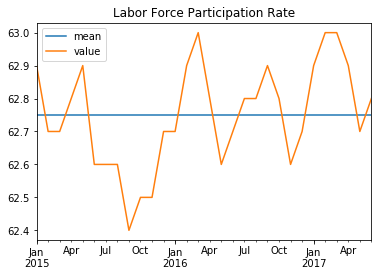

In [5]:
# Simple line plot of results
pd.DataFrame({'value':s, 
              'mean': s.mean()}).plot(
    title='Labor Force Participation Rate')

### Slightly more complex example -- multiple series
Use the BLS API v2 (which requires [registration](https://data.bls.gov/registrationEngine/)) to request more than one series at the same time. The version 2 API has a higher daily query limit, allows more years and series to be returned in each query, and allows some additional options such as requesting data in percent change rather than level. See [difference between v1 and v2](https://www.bls.gov/developers/api_faqs.htm#register1).

In [6]:
# The url for BLS API v2
url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'

# API key in config.py which contains: bls_key = 'key'
key = '?registrationkey={}'.format(config.bls_key)

# Series stored as a list
series_dict = {
    'LNS14000003': 'White', 
    'LNS14000006': 'Black', 
    'LNS14000009': 'Hispanic'}

# Start year and end year
dates = ('2008', '2017')

#### Post request for the data

This time we need to include some additional information with the request for data. Previously we used a *get* request, but if we want to submit data to be processed by the API we need to use a *post* request. See: [What is the difference between POST and GET?](https://stackoverflow.com/questions/3477333/what-is-the-difference-between-post-and-get) for more information.  

First, we will tell the API to provide data in json format by including a content-type entity header.

In [7]:
# Specify json as content type to return
headers = {'Content-type': 'application/json'}

# Submit the list of series as data
data = json.dumps({
    "seriesid": series_dict.keys(),
    "startyear": dates[0], 
    "endyear": dates[1]})

# Post request for the data
p = requests.post(
    '{}{}'.format(url, key), 
    headers=headers, 
    data=data).json()['Results']['series']

#### Loop through series and convert to pandas format

Since the API returns data in a uniform way, a loop can be used to apply formatting or other changes to all series in the returned json data. In the example below, I format both series as pandas dataframes with a datetime index and the values converted to floats. 

In [8]:
# Empty dictionary to fill with values
d = {}

# Build a pandas series from the API results, p
for s in p:
    d[series_dict[s['seriesID']]] = pd.Series(
        index = pd.to_datetime(
            ['{} {}'.format(i['period'], i['year']) for i in s['data']]),
        data = [i['value'] for i in s['data']]
        ).astype(float).iloc[::-1]
    
# Combine series into one pandas dataframe
df = pd.DataFrame(d)

# Show last 5 results
df.tail()

,Black,Hispanic,White
2017-02-01,8.1,5.6,4.1
2017-03-01,8.0,5.1,3.9
2017-04-01,7.9,5.2,3.8
2017-05-01,7.5,5.2,3.7
2017-06-01,7.1,4.8,3.8


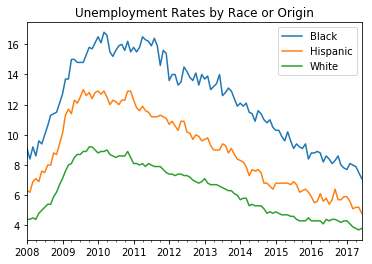

In [9]:
# Simple line plot of the data
df.plot(title='Unemployment Rates by Race or Origin')

### Multiple series, multiple decades

Even the version 2 API places limits on how many years worth of data can be returned in each request. For queries that require a longer time series, more than one request may be needed. 

This third example retrieves data on construction sector job openings and hires since 2000. 

In [10]:
# Include the start and end year here
date_r = (2000, 2017)

dates = [(str(date_r[0]), str(date_r[1]))]
while int(dates[-1][1]) - int(dates[-1][0]) > 10:
    dates = [(str(date_r[0]), str(date_r[0]+9))]
    d1 = int(dates[-1][0])
    while int(dates[-1][1]) < date_r[1]:
        d1 = d1 + 10
        d2 = min([date_r[1], d1+9])
        dates.append((str(d1),(d2)))   
        
dates    

[('2000', '2009'), ('2010', 2017)]

#### API and series information

In [11]:
# URL, key, and headers same as above
url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
key = '?registrationkey={}'.format(config.bls_key)
headers = {'Content-type': 'application/json'}

# This time, store the series into a dictionary with description
series_dict = {'JTU23000000JOL': 'Construction Job Openings (Thousands)',
               'LNU03032231': 'Unemployed Construction Workes (Thousands)'}

#### Make requests for each date range in dates

In [12]:
df = pd.DataFrame()
for start, end in dates: 
    # Submit the list of series as data
    data = json.dumps({
        "seriesid": series_dict.keys(),
        "startyear": start, 
        "endyear": end})

    # Post request for the data
    p = requests.post(
        '{}{}'.format(url, key), 
        headers=headers, 
        data=data).json()['Results']['series']
    d = {}
    # Build a pandas series from the API results, p
    for s in p:
        d[series_dict[s['seriesID']]] = pd.Series(
            index = pd.to_datetime(
                ['{} {}'.format(i['period'], i['year']) for i in s['data']]),
            data = [i['value'] for i in s['data']]
            ).astype(float).iloc[::-1]
        if len(p) == 0:
            d[series_dict[s['seriesID']]] = pd.Series()
    # Combine series into one pandas dataframe
    df = df.append(pd.DataFrame(d)).dropna()
    
# Unemployed per job opening
df['Unemployed per opening'] = df.iloc[:,1].divide(df.iloc[:,0]).round(1)

# Show last 5 results
df.tail()

KeyError: 'series'